In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import sys
from scipy.optimize import minimize
from tqdm import tqdm
from common import tool_times
from common import well_construction as wc
from common.sensor_types import sensors
from solvers.solver_cim_py.interface import Solver
import torch
import plotly
import plotly.graph_objs as go
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from typing import Tuple
import torch
import torch.optim as optim
from model import Net
model = torch.load('model_weights/modelentire.pth')
model.load_state_dict(torch.load('model_weights/model.pth'))
loss_function = nn.MSELoss()
model.eval()

def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device

device = get_device()
net = model.double().to(device)

def weighted_mse(u_exp: np.ndarray, u: np.ndarray, time: np.ndarray, eps: float = + 10 ** (-15)) -> Tuple[np.ndarray, np.ndarray]:
    dt = np.diff(time, n=1, axis=0)
    dt = np.append(dt, dt[-1])
    amplitude = np.dot(dt, u * u_exp) / np.dot(dt, u ** 2)
    e = (u_exp - amplitude * u) / (u_exp + eps) * dt
    
    loss = np.dot(e, e)
    return loss



t = 1e-3 * np.array([
    0.135, 0.180, 0.235, 0.315, 0.365, 0.420,
    0.485, 0.560, 0.650, 0.750, 0.865, 1.000,
    1.155, 1.335, 1.540, 1.780, 2.055, 2.370,
    2.740, 3.160, 3.650, 4.215, 4.870, 5.625,
    6.495, 7.500, 8.660, 10.00, 11.55, 13.34,
    15.40, 17.79, 20.54, 23.72, 27.39, 31.63,
    36.52, 42.17, 48.70, 56.24, 64.94, 74.99,
    86.60, 100.0, 115.5, 133.4
])

df = pd.read_pickle('Dataset')
# #fix_normed_vector = df.sample(1) временно
# fix_normed_vector = df.loc[9030]
# fix_normed_vector = pd.DataFrame(fix_normed_vector).transpose()
# print ('Зафиксировали произвольный вектор из датафрейма с компонентами \n')
# fix_normed_vector

## Считаем лосс (сигма, мю) через модельную функцию

### Нахождение границ для оптимизатора с учетом параметров усреднения первоначальной выборки

In [53]:
means = np.fromfile('means_scaler')
#print(means)
stds = np.fromfile('stds_scaler')
##########################################################
#временно для графиков
real_min_mu = 50
norm_min_mu = (real_min_mu - means[1]) / stds[1]
real_max_mu = 180
norm_max_mu = (real_max_mu - means[1]) / stds[1]
###########################################################
norm_min_sigma =  df.describe()['Sigma']['min'] 
# #print ('norm min sigma ',norm_min_sigma )

real_min_sigma =  norm_min_sigma * stds[0] + means[0]
print ('real min sigma ', real_min_sigma)

norm_max_sigma = df.describe()['Sigma']['max']
# #print ('norm max sigma ', norm_max_sigma )

real_max_sigma = norm_max_sigma * stds[0] + means[0]
print ('real max sigma ', real_max_sigma)


# norm_min_mu = df.describe()['mu']['min']
# #print ('norm min mu', norm_min_mu)

# real_min_mu = norm_min_mu * stds[1] + means[1]
# print('real min mu ', real_min_mu)

# norm_max_mu = df.describe()['mu']['max']
# #print ('norm max mu ', norm_max_mu)

# real_max_mu = norm_max_mu * stds[1] + means[1]
# print ('real max mu ', real_max_mu)

# #fix_real_vector = df.sample(1)
# fix_real_vector = fix_normed_vector[['Sigma', 'mu', 'd', 'th', 'th0']]
# fix_real_vector = fix_real_vector*stds+means
# fix_real_vector['Decay'] = fix_normed_vector['Decay']
# print ('Зафиксировали произвольный вектор из датафрейма с real компонентами \n')
# fix_real_vector

real min sigma  1000013.7854274483
real max sigma  9999922.0430012


In [3]:

import scipy.io
mat = scipy.io.loadmat('Solver2D_Pulse_3E_SS_3x12_v1.mat')
fix_real_vector = {'Sigma': [5302177], 'mu':[166], 'd':[89], 'th': [5.94], 'th0': [5.94]}
fix_real_vector = pd.DataFrame(data=fix_real_vector)
fix_normed_vector = (fix_real_vector - means) / stds
tmp = []
tmp.append(mat['solv_decay'][0])
fix_real_vector['Decay'] = tmp
fix_real_vector

,Sigma,mu,d,th,th0,Decay
0,5302177,166,89,5.94,5.94,"[0.19722413037917708, 0.18707293984095905, 0.1..."


In [4]:
fix_normed_vector['Decay'] = tmp
fix_normed_vector

,Sigma,mu,d,th,th0,Decay
0,-0.075661,2.126981,0.0,-0.076213,-0.56,"[0.19722413037917708, 0.18707293984095905, 0.1..."


### Подсчет и построение тепловых карт лосса с помощью нейросети и модельной функции

In [5]:
def model_decay(d=fix_real_vector.get('d').iloc[0], th0=fix_real_vector.get('th0').iloc[0],
                th=fix_real_vector.get('th').iloc[0], sigma=fix_real_vector.get('Sigma').iloc[0],
                mu=fix_real_vector.get('mu').iloc[0]):
    tubes = [
        wc.Tube(d=(d), th0=(th0), th=(th), sigma=(sigma), mu=(mu)),
    ]

    sensor = sensors.PULSE_3E_1
    times = tool_times.times[sensor]
    solver = Solver(sensor, times, tool_averaging=True, verbose=0)
    output = solver.get_curve(tubes)
    return(output)

def model_loss(real_sigma,real_mu):
    return np.log(weighted_mse(np.array(fix_real_vector.get('Decay').iloc[0]), np.array(model_decay(sigma=real_sigma,
                                                                             mu=real_mu)),t))
def net_loss(norm_sigma, norm_mu):
    tensor = torch.tensor([fix_normed_vector.get('Sigma').iloc[0],norm_sigma,
                           fix_normed_vector.get('mu').iloc[0],norm_mu,
                           fix_normed_vector.get('th').iloc[0],fix_normed_vector.get('th').iloc[0]])
    tensor = tensor.to(device)
    output = net(tensor.double())
    return (output.item())

def l2_norm(norm_sigma, norm_mu):
     return np.linalg.norm([fix_normed_vector.get('Sigma').iloc[0] - norm_sigma,
                          fix_normed_vector.get('mu').iloc[0] - norm_mu])

def model_minimization_function(variable_vector, constant=0.5):
    real_sigma = variable_vector[0]
    real_mu = variable_vector[1]
    norm_sigma = (real_sigma - means[0]) / stds[0]
    norm_mu = (real_mu - means[1]) / stds[1]
    return (-1 * l2_norm(norm_sigma, norm_mu) + constant * model_loss(real_sigma, real_mu))

def net_minimization_function(variable_vector, constant=0.5):
    real_sigma = variable_vector[0]
    real_mu = variable_vector[1]
    norm_sigma = (real_sigma - means[0]) / stds[0]
    norm_mu = (real_mu - means[1]) / stds[1]
    return (-1 * l2_norm(norm_sigma, norm_mu) + constant * net_loss(real_sigma, real_mu))

#### Вычисление и построение карты model_loss and net_loss 

In [6]:
size = 30
sigma_real = np.linspace(real_min_sigma, real_max_sigma, num=size, retstep=True)#sigma
mu_real = np.linspace(real_min_mu, real_max_mu, num=size, retstep=True)#mu
i = 0
j = 0
loss_model = np.zeros((size,size))

In [7]:
import time
startTime = time.time() # время начала замер
for i in tqdm(range(size)):
    while (j < size):
        loss_model[i,j] = model_loss(sigma_real[0][j],mu_real[0][i])
        j = j + 1
    j = 0
endTime = time.time() #время конца замера
totalTime = endTime - startTime #вычисляем затраченное время
print("Время, затраченное на выполнение данного кода = ", totalTime)
loss_model = pd.DataFrame(loss_model)
loss_model.index = np.around(mu_real[0],1) 
loss_model.columns = np.around(sigma_real[0]/1000000,1)
loss_model.to_pickle('./loss_model_model_matrix.pkl')
#loss_model = pd.read_pickle('./loss_model_model_matrix.pkl')

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [21:00<00:00, 42.00s/it]

Время, затраченное на выполнение данного кода =  1260.035340309143


In [7]:
loss_model = pd.read_pickle('./loss_model_model_matrix.pkl')

In [46]:
import time
i = 0
j = 0
loss_net = np.zeros((size, size))
sigma_norm = (sigma_real[0] - means[0]) / stds[0] 
mu_norm = (mu_real[0] - means[1]) / stds[1]

startTime = time.time() # время начала замер
for i in tqdm(range(size)):
    while (j < size):
        loss_net[i][j] = net_loss(sigma_norm[j], mu_norm[i])
        j += 1
    j = 0
endTime = time.time() #время конца замера
totalTime = endTime - startTime #вычисляем затраченное время

print("Время, затраченное на выполнение данного кода = ", totalTime)
loss_net = pd.DataFrame(loss_net)
# loss_net.index = np.around(mu_real[0],1) 
# loss_net.columns = np.around(sigma_real[0],3)
loss_net.index = np.around(mu_real[0],1)
loss_net.columns = np.around(sigma_real[0]/1000000,1)
loss_net.to_pickle('./loss_net_model_matrix.pkl')
#loss_net = pd.read_pickle('./loss_net_model_matrix.pkl')

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 76.99it/s]

Время, затраченное на выполнение данного кода =  0.3984375


In [8]:
loss_net = pd.read_pickle('./loss_net_model_matrix.pkl')

#### Разница результатов классического и нейросетевого подхода логарифмическая

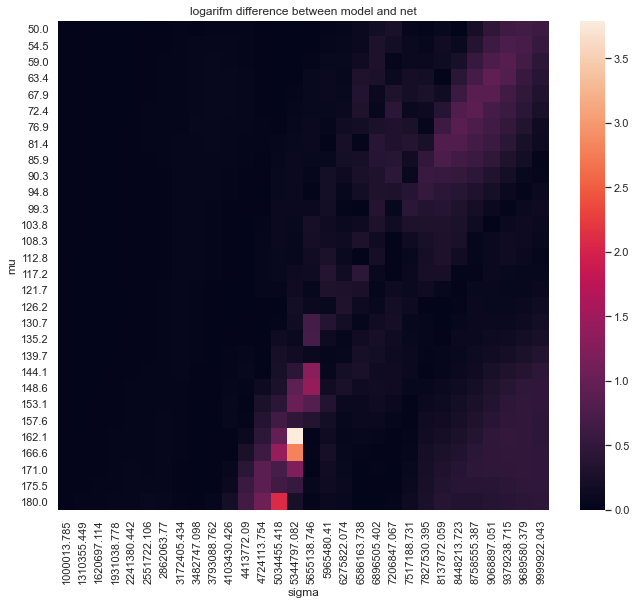

In [9]:
diff = abs(loss_model - loss_net)
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(diff, annot=False, vmin=0)
#name = 'log( loss( (' + str(fix_vector.get('mu').iloc[0])+ ', (' + str(fix_vector.get('Sigma').iloc[0]) + ')))'
name = "logarifm difference between model and net"
ax.set(xlabel='sigma', ylabel='mu', title=name)
# ax = f.gca()
# circle1 = plt.Circle((size/2,size/2), 0.5, color='g', fill=False, label="The zone of the fix vector")
# ax.add_patch(circle1)
# ax.legend()
f.savefig(name + '.png', bbox_inches='tight')

#### Разница результатов классического и нейросетевого подхода реальных данных

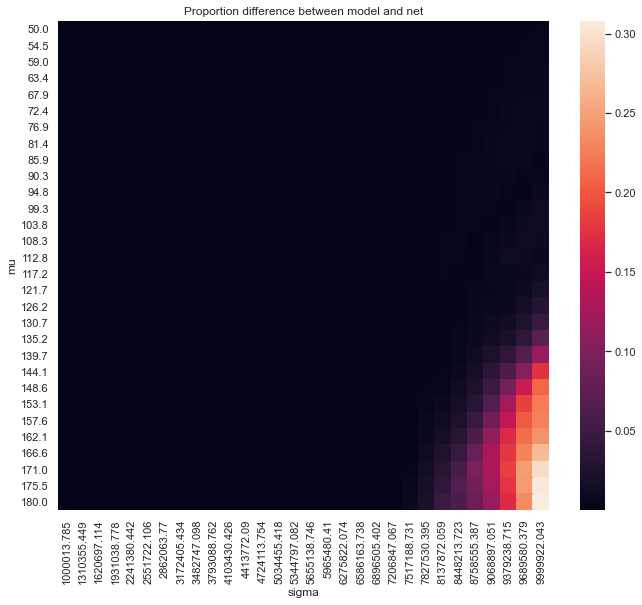

In [10]:
diff = abs(np.exp(loss_model) - np.exp(loss_net))
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(diff, annot=False)
#name = 'log( loss( (' + str(fix_vector.get('mu').iloc[0])+ ', (' + str(fix_vector.get('Sigma').iloc[0]) + ')))'
name = "Proportion difference between model and net"
ax.set(xlabel='sigma', ylabel='mu', title=name)
# ax = f.gca()
# circle1 = plt.Circle((size/2,size/2), 0.5, color='g', fill=False, label="The zone of the fix vector")
# ax.add_patch(circle1)
# ax.legend()
f.savefig(name + '.png', bbox_inches='tight')

#### Тепловая карта спадов модельных данных и нейросети

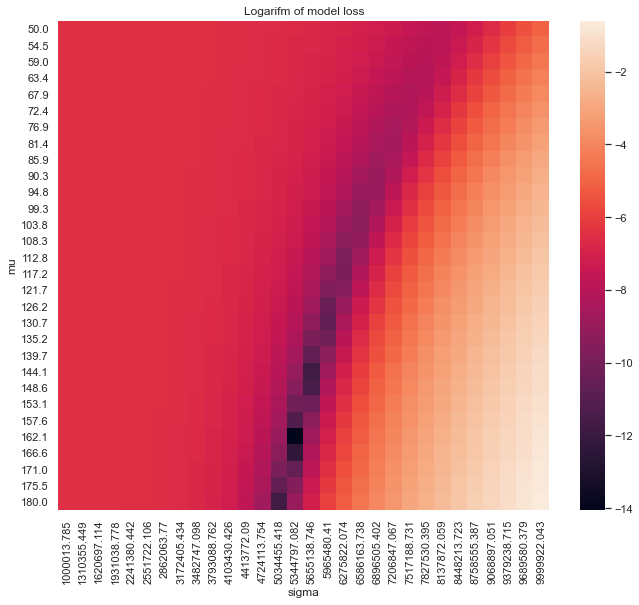

In [11]:
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(loss_model, annot=False)
name = "Logarifm of model loss"
ax.set(xlabel='sigma', ylabel='mu', title=name)
f.savefig(name + '.png', bbox_inches='tight')

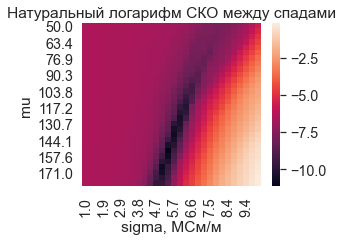

In [147]:
f, ax = plt.subplots(figsize=(4, 3))
sns.heatmap(loss_net, annot=False)
name = "Натуральный логарифм СКО между спадами"
ax.set(xlabel='sigma, МСм/м', ylabel='mu', title=name)
sns.set(font_scale=1.3) 
f.savefig(name + '.png', bbox_inches='tight')

### Подсчет и построение тепловой карты л2 нормы

In [59]:
sigma_norm = (sigma_real[0] - means[0]) / stds[0] 
mu_norm = (mu_real[0] - means[1]) / stds[1]
l2 = np.zeros((size, size))
i = 0
j = 0
for i in tqdm(range(size)):
    while (j < size):
        l2[i][j] = l2_norm(sigma_norm[j], mu_norm[i])
        j += 1
    j = 0
l2 = pd.DataFrame(l2)
l2.index = np.around(mu_real[0],1) 
l2.columns = np.around(sigma_real[0]/1000000,1)
l2.to_pickle('./l2_matrix.pkl')
#l2 = pd.read_pickle('./l2_matrix.pkl')

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 849.81it/s]


In [60]:
l2 = pd.read_pickle('./l2_matrix.pkl')

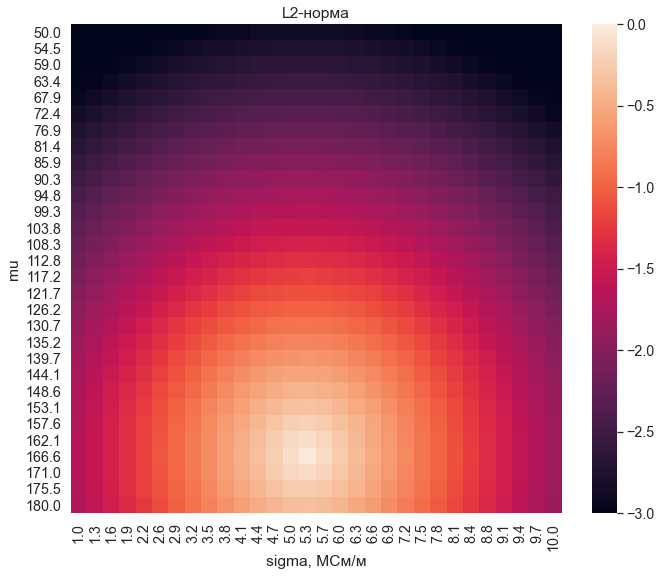

In [71]:
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(-l2, annot=False, vmax=0, vmin=-3)
name = "L2-норма"
ax.set(xlabel='sigma, МСм/м', ylabel='mu', title=name)
sns.set(font_scale=1.3) 
f.savefig(name + '.png', bbox_inches='tight')

### Взвешенная сумма -l2_norm + constant * loss_model

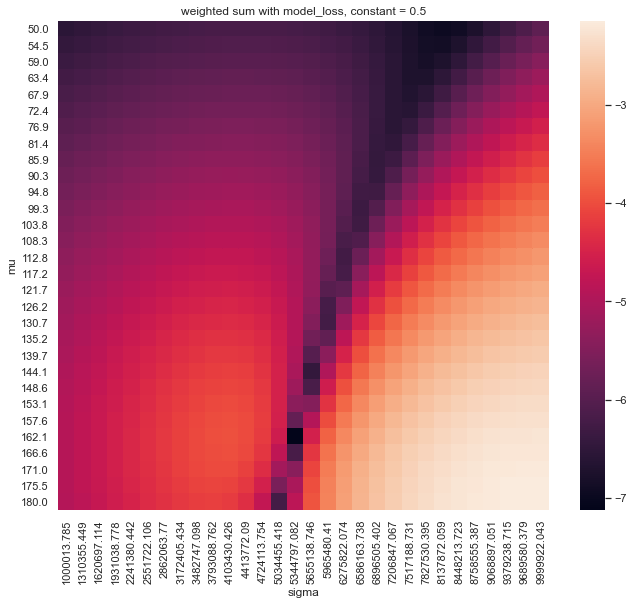

In [17]:
constant = 0.5
weighted_sum = -l2 + constant * loss_model
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(weighted_sum, annot=False)
name = "weighted sum with model_loss, constant = " + str(constant)
ax.set(xlabel='sigma', ylabel='mu', title=name)
f.savefig(name + '.png', bbox_inches='tight')

### Взвешенная сумма -l2_norm + constant * loss_model

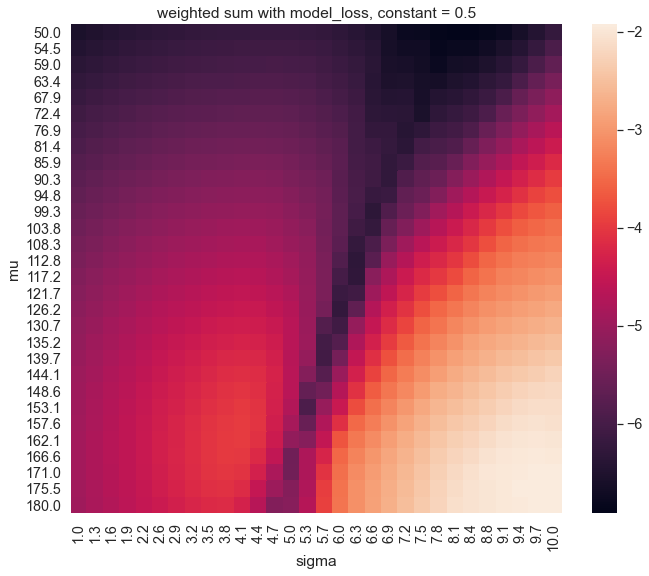

In [131]:
constant = 0.5
weighted_sum = -l2 + constant * loss_net
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(weighted_sum, annot=False)
name = "weighted sum with model_loss, constant = " + str(constant)
ax.set(xlabel='sigma', ylabel='mu', title=name)
f.savefig(name + '.png', bbox_inches='tight')

### SLSQP

In [141]:
minimize_result_data_slsqp = []
history_net_slsqp = []
def callbackF(xk):
    print({'sigma': xk[0] * stds[0] + means[0],
                   'mu':xk[1] * stds[1] + means[1]})
    history_net_slsqp.append({'sigma': xk[0] * stds[0] + means[0],
                   'mu':xk[1] * stds[1] + means[1]})
constant =  np.array([constant])
for const in tqdm(constant):
    def net_minimization_function(norm_variable_vector, constant=const):
        real_sigma = norm_variable_vector[0] * stds[0] + means[0]
        real_mu = norm_variable_vector[1] * stds[1] + means[1]
        norm_sigma = norm_variable_vector[0]
        norm_mu = norm_variable_vector[1]
        return (-1 * l2_norm(norm_sigma, norm_mu) + constant * net_loss(norm_sigma, norm_mu))
    x0 = np.array([fix_normed_vector.get('Sigma').iloc[0],fix_normed_vector.get('mu').iloc[0]])
    res =  minimize(net_minimization_function, x0, method='SLSQP', callback=callbackF,bounds=((norm_min_sigma,norm_max_sigma),
                                                                   (norm_min_mu,norm_max_mu)),
                    options={'disp': False,'maxiter':1e6,})
    minimize_result_data_slsqp.append({'l2_norm': l2_norm(res.x[0], res.x[1]),
                                 'log_loss': model_loss(res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1]),
                                 'loss': np.exp(model_loss(res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1])),
                                 'constant': const, 'data': (res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1]),
                                 'message': res.message})
minimize_result_data_slsqp = pd.DataFrame(minimize_result_data_slsqp)
minimize_result_data_slsqp
#print(res)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

{'sigma': 1000013.7854274483, 'mu': 58.009451491686875}
{'sigma': 5673698.1907699, 'mu': 139.53169343383607}
{'sigma': 7577959.148422063, 'mu': 50.0}
{'sigma': 7575919.607034933, 'mu': 50.0}
{'sigma': 7565712.810569301, 'mu': 50.000000000000334}
{'sigma': 7514451.195009749, 'mu': 50.00000000000337}
{'sigma': 7252406.748496186, 'mu': 50.0}
{'sigma': 6059159.803960804, 'mu': 50.0}
{'sigma': 1000013.7854275443, 'mu': 50.0}
{'sigma': 1000013.7854274632, 'mu': 50.00000000000228}
{'sigma': 1000013.7854274483, 'mu': 50.00000000000007}
{'sigma': 1000013.7857489344, 'mu': 50.0}
{'sigma': 1000014.1140132872, 'mu': 50.0}


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.35s/it]


,l2_norm,log_loss,loss,constant,data,message
0,2.977726,-7.435516,0.00059,[0.5],"(7354418.30026695, 50.00000000000211)",Optimization terminated successfully


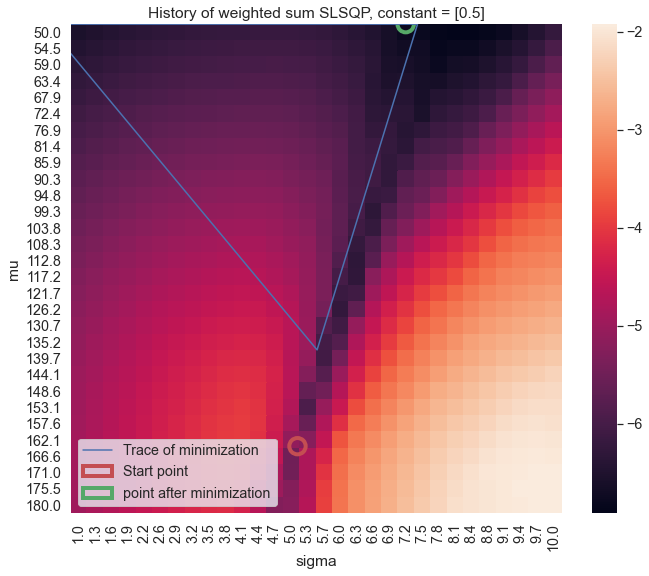

In [142]:
real_sigma_new = minimize_result_data_slsqp.iloc[0]['data'][0]
real_mu_new = minimize_result_data_slsqp.iloc[0]['data'][1]
#constant = minimize_result_data_7.iloc[0]['constant']
sigma_history = []
mu_history = []
for i in history_net_slsqp:
    sigma_history.append((i['sigma'] - sigma_real[0][0]) / sigma_real[1])
    mu_history.append((i['mu'] - mu_real[0][0]) / mu_real[1])
#weighted_sum = -l2 + constant * loss_net
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(weighted_sum, annot=False)
name = "History of weighted sum SLSQP, constant = " + str(constant[0])
ax.set(xlabel='sigma', ylabel='mu', title=name)
ax = f.gca()
circle0 = plt.Circle(((fix_real_vector.get('Sigma').iloc[0] - sigma_real[0][0])/sigma_real[1],
                      (fix_real_vector.get('mu').iloc[0] - mu_real[0][0])/mu_real[1]),
                     0.5, color='r', fill=False, label="Start point", linewidth=4)
ax.add_patch(circle0)
circle1 = plt.Circle(((real_sigma_new - sigma_real[0][0])/sigma_real[1],(real_mu_new - mu_real[0][0])/mu_real[1]),
                     0.5, color='g', fill=False, label="point after minimization", linewidth=4)
ax.add_patch(circle1)
plt.plot(sigma_history, mu_history, label="Trace of minimization")
ax.legend()
f.savefig(name + '.png', bbox_inches='tight')

#### Оптимизация функции нормированных величин

## Trust-Constr

In [143]:
history_TC = []
def callbackF(xk, result):
    history_TC.append({'sigma': xk[0] * stds[0] + means[0],
                   'mu':xk[1] * stds[1] + means[1]})
    #print ('there is xk', [xk[0] * stds[0] + means[0], xk[1] * stds[1] + means[1]])
minimize_result_data = []
#constant = np.array([minimize_result_data_net.iloc[5]['constant']])
constant =  np.array([0.5])
history_TC.append({'sigma':fix_normed_vector.get('Sigma').iloc[0] * stds[0] + means[0],
                   'mu':fix_normed_vector.get('mu').iloc[0] * stds[1] + means[1]})
for const in tqdm(constant):
    def net_minimization_function(norm_variable_vector, constant=const):
        real_sigma = norm_variable_vector[0] * stds[0] + means[0]
        real_mu = norm_variable_vector[1] * stds[1] + means[1]
        norm_sigma = norm_variable_vector[0]
        norm_mu = norm_variable_vector[1]
        return (-1 * l2_norm(norm_sigma, norm_mu) + constant * net_loss(norm_sigma, norm_mu))
    x0 = np.array([fix_normed_vector.get('Sigma').iloc[0],fix_normed_vector.get('mu').iloc[0]])
    res =  minimize(net_minimization_function, x0, method='trust-constr', callback=callbackF,bounds=((norm_min_sigma,norm_max_sigma),
                                                                   (norm_min_mu,norm_max_mu))
                    ,options={'disp': False, 'xtol':1e-15, 'initial_constr_penalty': 0.1,
                              'maxiter':1e10, 'initial_tr_radius': 0.5
                             })
    minimize_result_data.append({'l2_norm': l2_norm(res.x[0], res.x[1]),
                                 'log_loss': model_loss(res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1]),
                                 'loss': np.exp(model_loss(res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1])),
                                 'constant': const, 'data': (res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1]),
                                 'message': res.message})
minimize_result_data = pd.DataFrame(minimize_result_data)
minimize_result_data

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.53s/it]


,l2_norm,log_loss,loss,constant,data,message
0,1.620749,-9.368878,0.000085,0.5,"(6495543.761902655, 103.20407160531983)",`xtol` termination condition is satisfied.


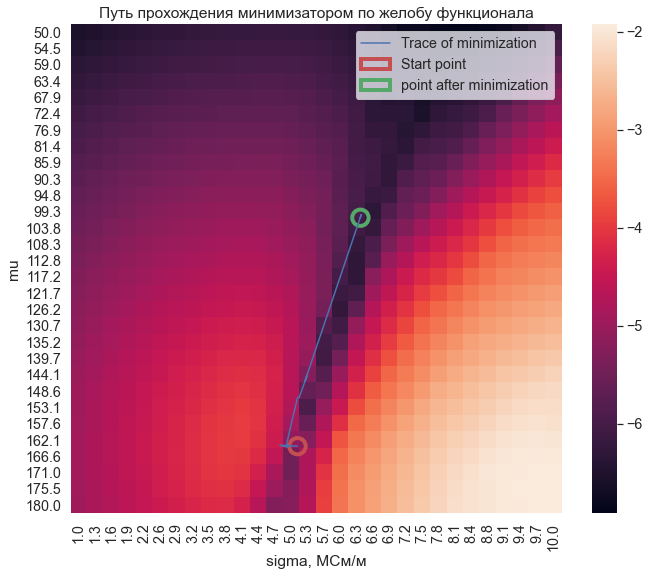

In [144]:
real_sigma_new = minimize_result_data.iloc[0]['data'][0]
real_mu_new = minimize_result_data.iloc[0]['data'][1]
#constant = minimize_result_data_7.iloc[0]['constant']
sigma_history_TC = []
mu_history_TC = []
for i in history_TC:
    sigma_history_TC.append((i['sigma'] - sigma_real[0][0]) / sigma_real[1])
    mu_history_TC.append((i['mu'] - mu_real[0][0]) / mu_real[1])
#weighted_sum = -l2 + constant * loss_net
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(weighted_sum, annot=False)
name = "Путь прохождения минимизатором по желобу функционала" 
ax.set(xlabel='sigma, МСм/м', ylabel='mu', title=name)
ax = f.gca()
circle0 = plt.Circle(((fix_real_vector.get('Sigma').iloc[0] - sigma_real[0][0])/sigma_real[1],
                      (fix_real_vector.get('mu').iloc[0] - mu_real[0][0])/mu_real[1]),
                     0.5, color='r', fill=False, label="Start point", linewidth=4)
ax.add_patch(circle0)
circle1 = plt.Circle(((real_sigma_new - sigma_real[0][0])/sigma_real[1],(real_mu_new - mu_real[0][0])/mu_real[1]),
                     0.5, color='g', fill=False, label="point after minimization", linewidth=4)
ax.add_patch(circle1)
plt.plot(sigma_history_TC, mu_history_TC, label="Trace of minimization")
ax.legend()
f.savefig(name + '.png', bbox_inches='tight')

## BFGS

In [145]:
history_net_bfgs = []
def callbackF(xk):
    print({'sigma': xk[0] * stds[0] + means[0],
                   'mu':xk[1] * stds[1] + means[1]})
    history_net_bfgs.append({'sigma': xk[0] * stds[0] + means[0],
                   'mu':xk[1] * stds[1] + means[1]})
    #print ('there is xk', [xk[0] * stds[0] + means[0], xk[1] * stds[1] + means[1]])
minimize_result_data_bfgs = []
#constant = np.array([minimize_result_data_net.iloc[5]['constant']])
history_net_bfgs.append({'sigma': fix_normed_vector.get('Sigma').iloc[0] * stds[0] + means[0],
                         'mu':fix_normed_vector.get('mu').iloc[0] * stds[1] + means[1]})
for const in tqdm(constant):
    def net_minimization_function(norm_variable_vector, constant=const):
        real_sigma = norm_variable_vector[0] * stds[0] + means[0]
        real_mu = norm_variable_vector[1] * stds[1] + means[1]
        norm_sigma = norm_variable_vector[0]
        norm_mu = norm_variable_vector[1]
        return (-1 * l2_norm(norm_sigma, norm_mu) + constant * net_loss(norm_sigma, norm_mu))
    x0 = np.array([fix_normed_vector.get('Sigma').iloc[0],fix_normed_vector.get('mu').iloc[0]])
    res =  minimize(net_minimization_function, x0, method='L-BFGS-B', callback=callbackF,bounds=((norm_min_sigma,norm_max_sigma),
                                                                   (norm_min_mu,norm_max_mu))
                    ,options={'disp': False,
                             })
    minimize_result_data_bfgs.append({'l2_norm': l2_norm(res.x[0], res.x[1]),
                                 'log_loss': model_loss(res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1]),
                                 'loss': np.exp(model_loss(res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1])),
                                 'constant': const, 'data': (res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1]),
                                 'message': res.message})
minimize_result_data_bfgs = pd.DataFrame(minimize_result_data_bfgs)
minimize_result_data_bfgs

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

{'sigma': 1000013.7854274483, 'mu': 58.00946006057713}
{'sigma': 1000013.7854274483, 'mu': 50.0}


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.01s/it]


,l2_norm,log_loss,loss,constant,data,message
0,3.31702,-6.448071,0.001584,0.5,"(1000013.7854274483, 50.0)",b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_P...


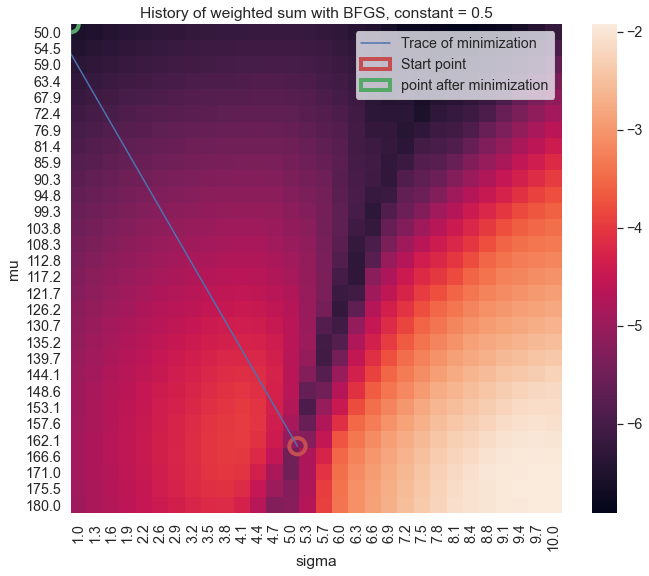

In [146]:
real_sigma_new = minimize_result_data_bfgs.iloc[0]['data'][0]
real_mu_new = minimize_result_data_bfgs.iloc[0]['data'][1]
#constant = minimize_result_data_7.iloc[0]['constant']
#constant = 0.65
sigma_history = []
mu_history = []
for i in history_net_bfgs:
    sigma_history.append((i['sigma'] - sigma_real[0][0]) / sigma_real[1])
    mu_history.append((i['mu'] - mu_real[0][0]) / mu_real[1])
#weighted_sum = -l2 + constant * loss_net
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(weighted_sum, annot=False)
name = "History of weighted sum with BFGS, constant = " + str(constant[0])
ax.set(xlabel='sigma', ylabel='mu', title=name)
ax = f.gca()
circle0 = plt.Circle(((fix_real_vector.get('Sigma').iloc[0] - sigma_real[0][0])/sigma_real[1],
                      (fix_real_vector.get('mu').iloc[0] - mu_real[0][0])/mu_real[1]),
                     0.5, color='r', fill=False, label="Start point", linewidth=4)
ax.add_patch(circle0)
circle1 = plt.Circle(((real_sigma_new - sigma_real[0][0])/sigma_real[1],
                      (real_mu_new - mu_real[0][0])/mu_real[1]),
                     0.5, color='g', fill=False, label="point after minimization", linewidth=4)
ax.add_patch(circle1)
plt.plot(sigma_history, mu_history, label="Trace of minimization")
ax.legend()
f.savefig(name + '.png', bbox_inches='tight')

### Trust-constr сработал удовлетворительнее всех. Спады для каждой их его точек

100%|████████████████████████████████████████████████████████████████████████████████| 466/466 [00:14<00:00, 32.32it/s]


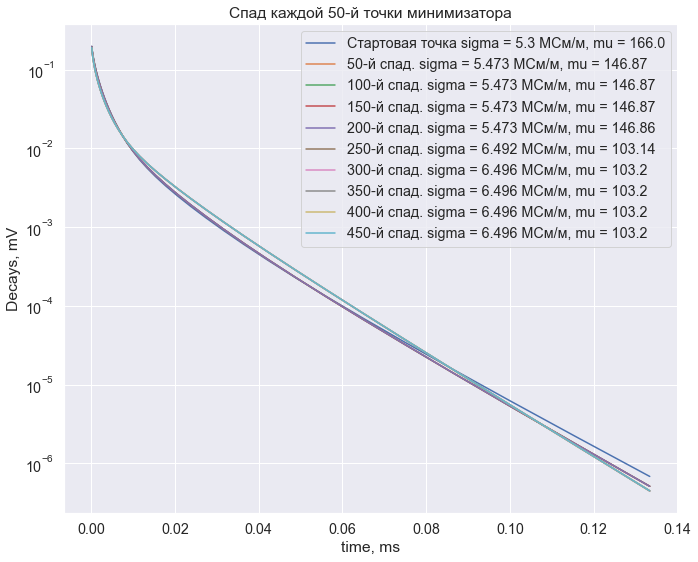

In [427]:
f, ax = plt.subplots(figsize=(11,9))
i = 0
labels = []
for data in tqdm(history_TC):
    if (i % 50 == 0):
        plt.plot(t, model_decay(sigma=data['sigma'], mu=data['mu']))
        if (i == 0):
            labels.append(r'Стартовая точка sigma = {} МСм/м, mu = {}'.format(str(np.around(data['sigma']/1e6,1)),
                                                                              str(np.around(data['mu'],1))))
        else:
            labels.append(r'{}-й спад. sigma = {} МСм/м, mu = {}'.format(i,str(np.around(data['sigma']/1e6,3)),
                                                                              str(np.around(data['mu'],2))))
    i+=1
plt.title('Спад каждой 50-й точки минимизатора')
plt.gca().set(xlabel='time, ms', ylabel='Decays, mV')
ax.set_yscale('log')
plt.legend(labels=labels)
f.savefig( 'Каждый спад.png', bbox_inches='tight')

## Градиентный спуск своими руками

In [239]:
bounds = {'sigma':(norm_min_sigma, norm_max_sigma),'mu':(norm_min_mu, norm_max_mu)}
bounds

{'sigma': (-1.7384717023084395, 1.7400442193406047),
 'mu': (-0.7431546180071851, 2.4733770971902778)}

In [265]:
eps = 1e-10

def net_minimization_function(norm_sigma, norm_mu, constant=0.5):
    real_sigma = norm_sigma * stds[0] + means[0]
    real_mu = norm_mu * stds[1] + means[1]
    return (-1 * l2_norm(norm_sigma, norm_mu) + constant * net_loss(norm_sigma, norm_mu))

def derivative_x(norm_sigma, norm_mu):
    return ( net_minimization_function(norm_sigma + eps, norm_mu) - net_minimization_function(norm_sigma, norm_mu) ) / eps

def derivative_y(norm_sigma, norm_mu):
    return  (net_minimization_function(norm_sigma, norm_mu + eps) - net_minimization_function(norm_sigma, norm_mu) ) / eps


### Спуск с постоянным шагом

In [443]:
trace = []
norm_sigma0 = fix_normed_vector.get('Sigma').iloc[0]
norm_mu0 = fix_normed_vector.get('mu').iloc[0]
trace.append({'sigma':norm_sigma0 * stds[0] + means[0], 
              'mu': norm_mu0 * stds[1] + means[1],
              'loss': net_minimization_function(norm_sigma0, norm_mu0)})
not_end = True
step=0.009
while(not_end):
    dx =  derivative_x(norm_sigma0, norm_mu0)
    dy =  derivative_y(norm_sigma0, norm_mu0)
    new_sigma = norm_sigma0 -  step*dx
    new_mu = norm_mu0 - step*dy
    if( (abs(net_minimization_function(new_sigma, new_mu) - net_minimization_function(norm_sigma0, norm_mu0)) < 1e-04) or
       (new_sigma > bounds['sigma'][1]) or (new_mu < bounds['mu'][0])):
        not_end = False
    trace.append({'sigma':new_sigma  * stds[0] + means[0],
                  'mu':new_mu  * stds[1] + means[1],
                  'loss':net_minimization_function(new_sigma, new_mu)})
    norm_sigma0 = new_sigma
    norm_mu0 = new_mu

history_gd = pd.DataFrame(trace)    

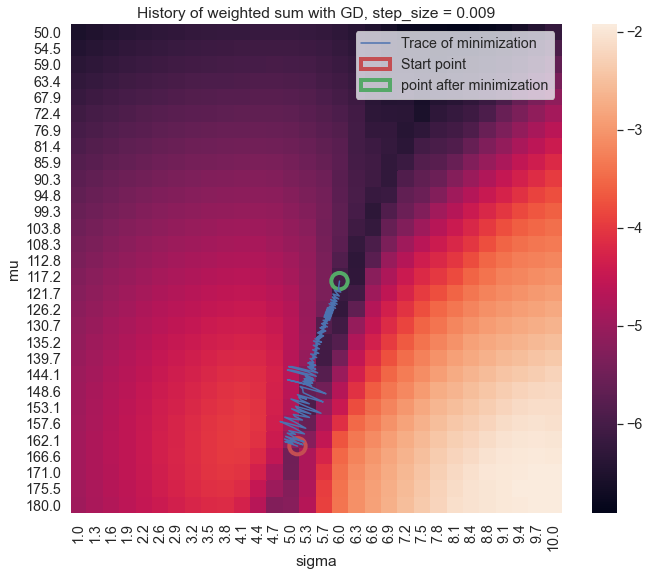

In [444]:
real_sigma_new = history_gd['sigma'].iloc[len(history_gd)-1]
real_mu_new =history_gd['mu'].iloc[len(history_gd)-1]
#constant = minimize_result_data_7.iloc[0]['constant']
#constant = 0.65
sigma_history = []
mu_history = []
for i in trace:
    sigma_history.append((i['sigma'] - sigma_real[0][0]) / sigma_real[1])
    mu_history.append((i['mu'] - mu_real[0][0]) / mu_real[1])
#weighted_sum = -l2 + constant * loss_net
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(weighted_sum, annot=False)
name = "History of weighted sum with GD, step_size = " + str(step)
ax.set(xlabel='sigma', ylabel='mu', title=name)
ax = f.gca()
circle0 = plt.Circle(((fix_real_vector.get('Sigma').iloc[0] - sigma_real[0][0])/sigma_real[1],
                      (fix_real_vector.get('mu').iloc[0] - mu_real[0][0])/mu_real[1]),
                     0.5, color='r', fill=False, label="Start point", linewidth=4)
ax.add_patch(circle0)
circle1 = plt.Circle(((real_sigma_new - sigma_real[0][0])/sigma_real[1],
                      (real_mu_new - mu_real[0][0])/mu_real[1]),
                     0.5, color='g', fill=False, label="point after minimization", linewidth=4)
ax.add_patch(circle1)
plt.plot(sigma_history, mu_history, label="Trace of minimization")
ax.legend()
f.savefig(name + '.png', bbox_inches='tight')

100%|████████████████████████████████████████████████████████████████████████████████| 204/204 [00:08<00:00, 23.66it/s]


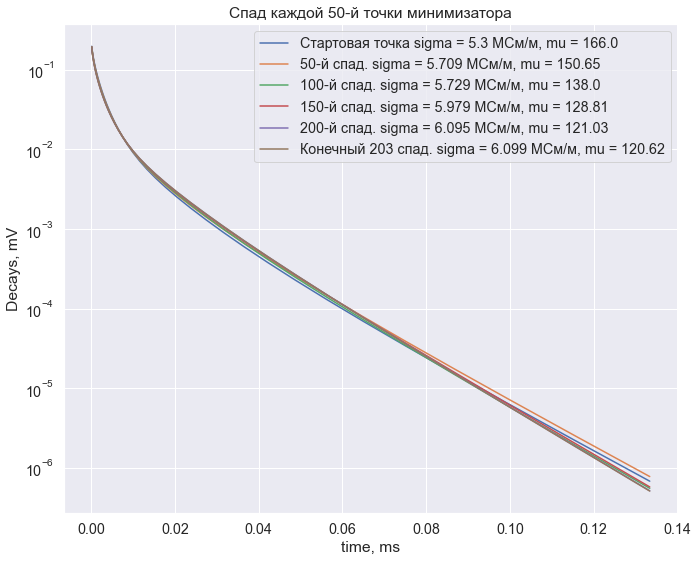

In [451]:
f, ax = plt.subplots(figsize=(11,9))
i = 0
labels = []
for data in tqdm(trace):
    if (i % 50 == 0):
        plt.plot(t, model_decay(sigma=data['sigma'], mu=data['mu']))
        if (i == 0):
            labels.append(r'Стартовая точка sigma = {} МСм/м, mu = {}'.format(str(np.around(data['sigma']/1e6,1)),
                                                                              str(np.around(data['mu'],1))))
        else:
            labels.append(r'{}-й спад. sigma = {} МСм/м, mu = {}'.format(i,str(np.around(data['sigma']/1e6,3)),
                                                                              str(np.around(data['mu'],2))))
    if (i == len(trace)-1):
        plt.plot(t, model_decay(sigma=data['sigma'], mu=data['mu']))
        labels.append(r'Конечный {} спад. sigma = {} МСм/м, mu = {}'.format(i,str(np.around(data['sigma']/1e6,3)),
                                                                              str(np.around(data['mu'],2))))
    i+=1
plt.title('Спад каждой 50-й точки минимизатора')
plt.gca().set(xlabel='time, ms', ylabel='Decays, mV')
ax.set_yscale('log')
plt.legend(labels=labels)
f.savefig( 'Каждый спад.png', bbox_inches='tight')

## Метод Нестерова (Доделать если будет время после презентации)

In [486]:
trace = []
norm_sigma0 = fix_normed_vector.get('Sigma').iloc[0]
norm_mu0 = fix_normed_vector.get('mu').iloc[0]
trace.append({'sigma':norm_sigma0 * stds[0] + means[0], 
              'mu': norm_mu0 * stds[1] + means[1],
              'loss': net_minimization_function(norm_sigma0, norm_mu0)})
not_end = True
step = 0.001
betta = 0.8
previous_sigma = norm_sigma0
previous_mu = norm_mu0
while(not_end):
    dx =  derivative_x(norm_sigma0+betta*(norm_sigma0-previous_sigma), norm_mu0)
    dy =  derivative_y(norm_sigma0, norm_mu0+betta*(norm_mu0-previous_mu))
    new_sigma = norm_sigma0 -  step*dx + betta*(norm_sigma0-previous_sigma)
    new_mu = norm_mu0 - step*dy + betta*(norm_mu0-previous_mu)
    if( (abs(net_minimization_function(new_sigma, new_mu) - net_minimization_function(norm_sigma0, norm_mu0)) < 1e-06) or
       (new_sigma > bounds['sigma'][1]) or (new_mu < bounds['mu'][0])):
        not_end = False
    trace.append({'sigma':new_sigma  * stds[0] + means[0],
                  'mu':new_mu  * stds[1] + means[1],
                  'loss':net_minimization_function(new_sigma, new_mu)})
    previous_sigma = norm_sigma0
    previous_mu = norm_mu0
    norm_sigma0 = new_sigma
    norm_mu0 = new_mu
    

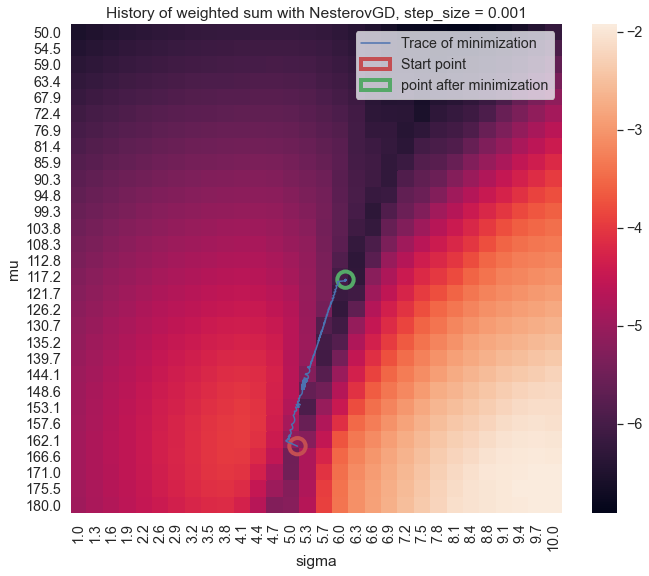

In [487]:
history_gd = pd.DataFrame(trace)
real_sigma_new = history_gd['sigma'].iloc[len(history_gd)-1]
real_mu_new =history_gd['mu'].iloc[len(history_gd)-1]
#constant = minimize_result_data_7.iloc[0]['constant']
#constant = 0.65
sigma_history = []
mu_history = []
for i in trace:
    sigma_history.append((i['sigma'] - sigma_real[0][0]) / sigma_real[1])
    mu_history.append((i['mu'] - mu_real[0][0]) / mu_real[1])
#weighted_sum = -l2 + constant * loss_net
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(weighted_sum, annot=False)
name = "History of weighted sum with NesterovGD, step_size = " + str(step)
ax.set(xlabel='sigma', ylabel='mu', title=name)
ax = f.gca()
circle0 = plt.Circle(((fix_real_vector.get('Sigma').iloc[0] - sigma_real[0][0])/sigma_real[1],
                      (fix_real_vector.get('mu').iloc[0] - mu_real[0][0])/mu_real[1]),
                     0.5, color='r', fill=False, label="Start point", linewidth=4)
ax.add_patch(circle0)
circle1 = plt.Circle(((real_sigma_new - sigma_real[0][0])/sigma_real[1],
                      (real_mu_new - mu_real[0][0])/mu_real[1]),
                     0.5, color='g', fill=False, label="point after minimization", linewidth=4)
ax.add_patch(circle1)
plt.plot(sigma_history, mu_history, label="Trace of minimization")
ax.legend()
f.savefig(name + '.png', bbox_inches='tight')

In [488]:
history_gd

,sigma,mu,loss
0,5.302177e+06,166.000000,-4.950205
1,5.281216e+06,165.892011,-5.043808
2,5.242690e+06,165.635534,-5.183987
3,5.194280e+06,165.290898,-5.344620
4,5.123691e+06,164.908154,-5.622028
...,...,...,...
4483,6.212808e+06,120.311981,-6.287911
4484,6.216125e+06,120.306543,-6.287736
4485,6.213468e+06,120.271677,-6.287968
4486,6.212366e+06,120.245572,-6.287771


100%|█████████████████████████████████████████████████████████████████████████████| 4488/4488 [00:14<00:00, 318.53it/s]


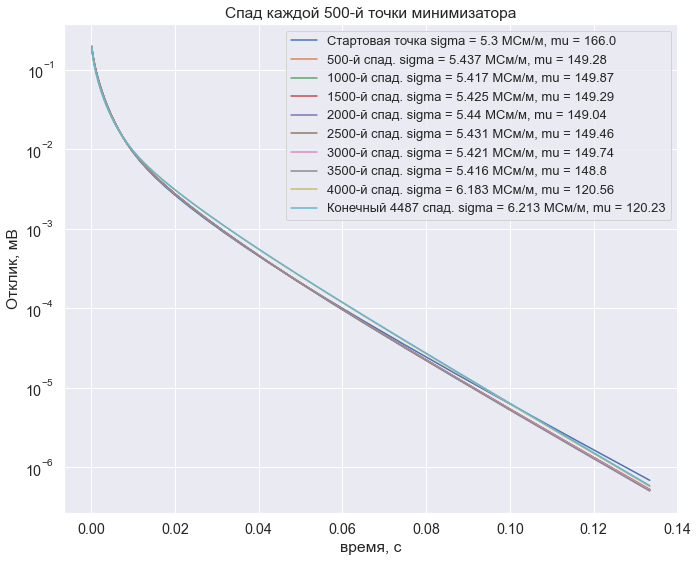

In [500]:
import matplotlib.font_manager as font_manager
f, ax = plt.subplots(figsize=(11,9))
i = 0
labels = []
for data in tqdm(trace):
    if (i % 500 == 0):
        plt.plot(t, model_decay(sigma=data['sigma'], mu=data['mu']))
        if (i == 0):
            labels.append(r'Стартовая точка sigma = {} МСм/м, mu = {}'.format(str(np.around(data['sigma']/1e6,1)),
                                                                              str(np.around(data['mu'],1))))
        else:
            labels.append(r'{}-й спад. sigma = {} МСм/м, mu = {}'.format(i,str(np.around(data['sigma']/1e6,3)),
                                                                              str(np.around(data['mu'],2))))
    if (i == len(trace)-1):
        plt.plot(t, model_decay(sigma=data['sigma'], mu=data['mu']))
        labels.append(r'Конечный {} спад. sigma = {} МСм/м, mu = {}'.format(i,str(np.around(data['sigma']/1e6,3)),
                                                                              str(np.around(data['mu'],2))))
    i+=1
font = font_manager.FontProperties(
                                   style='normal', size=13)
plt.title('Спад каждой 500-й точки минимизатора')
plt.gca().set(xlabel='время, с', ylabel='Отклик, мВ')
ax.set_yscale('log')
plt.legend(labels=labels,prop=font)
f.savefig( 'Каждый спад.png', bbox_inches='tight')

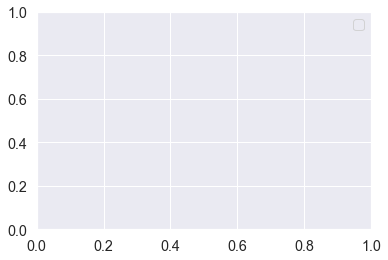

In [493]:

plt.legend(labels=labels)